<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/13b_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network con Convoluciones

Dado que las GAN tardan mucho más en entrenarse, las implementaciones de GAN tienden a usar capas más avanzadas. Leaky ReLU es uno de ellos, y el otro es Batch Normalization.

Normalizar la entrada es generalmente una buena idea. Si cada neurona de entrada tiene aproximadamente la misma escala, entonces se puede usar el mismo método para inicializar todos los pesos y sesgos.

Pero, ¿qué pasa con las activaciones ocultas?

Esa es la idea principal detrás de la normalización por lotes: se normalizan las activaciones ocultas para que tengan media 0 y desviación estándar 1 (o algún otro valor). A la hora del entrenamiento, se realiza la normalización en cada mini-batch, pero también se realiza un seguimiento de las medias y las desviaciones estándar de las activaciones entrantes. En la etapa de prueba (test time), se usan las medias y las desviaciones estándar aprendidas durante el entrenamiento para normalizar la entrada del test.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms

## Conjunto de datos

In [ ]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

## Modelo

La **convolución transpuesta** también se conoce como Deconvolución, lo cual no es apropiado ya que la deconvolución implica eliminar el efecto de convolución que no pretendemos lograr. También se conoce como **convolución sobremuestreada**, que es intuitiva para la tarea que se desea realizar, es decir, sobremuestrea el mapa de características de entrada.

> Los mapas azules son entradas y los mapas cian son salidas. [Más ejemplos aquí](https://github.com/vdumoulin/conv_arithmetic)

> **No padding, no strides, transposed**
<br>
![hola](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif?raw=true)
<br><br>

> **Padding, strides**<br>
![padding_strides](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, 7)
        )
    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0))
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 32, 7),
            nn.BatchNorm2d(32, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(8, 1, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), 100, 1, 1)
        out = self.model(x)
        return out

In [ ]:
# verificar si hay GPU disponible
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f'Dispositivo seleccionado: {device}\n')

Dispositivo seleccionado: cpu



### Training

In [ ]:
def train(generator, discriminator, lr=0.001, num_epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=100, shuffle=True)

    num_test_samples = 16
    test_noise = torch.randn(num_test_samples, 100)

    for epoch in range(num_epochs):
        # label that we are using both models 
        generator.train()
        discriminator.train()


        for n, (images, _) in enumerate(train_loader):
            # === Train the Discriminator ===

            noise = torch.randn(images.size(0), 100)
            fake_images = generator(noise)
            inputs = torch.cat([images, fake_images])
            labels = torch.cat([torch.zeros(images.size(0)), # real
                                torch.ones(images.size(0))]) # fake

            d_outputs = discriminator(inputs)
            d_loss = criterion(d_outputs, labels)
            d_loss.backward()
            d_optimizer.step()
            d_optimizer.zero_grad()

            # === Train the Generator ===
            noise = torch.randn(images.size(0), 100)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            g_loss = criterion(outputs, torch.zeros(images.size(0)))
            g_loss.backward()
            g_optimizer.step()
            g_optimizer.zero_grad()

        scores = torch.sigmoid(d_outputs)
        real_score = scores[:images.size(0)].data.mean()
        fake_score = scores[images.size(0):].data.mean()


        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f' 
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item(), real_score, fake_score))
        
        # plot images
        generator.eval()
        discriminator.eval()
        test_images = generator(test_noise)
        plt.figure(figsize=(9, 3))
        for k in range(16):
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].data.numpy().reshape(28, 28), cmap='Greys')
        plt.show()

Epoch [1/20], d_loss: 0.5343, g_loss: 0.3969, D(x): 0.00, D(G(z)): 0.34


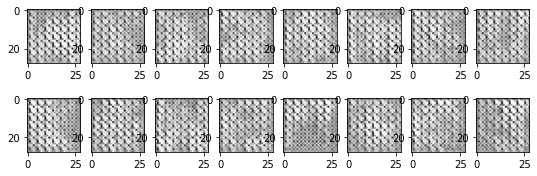

Epoch [2/20], d_loss: 0.5211, g_loss: 0.4022, D(x): 0.00, D(G(z)): 0.35


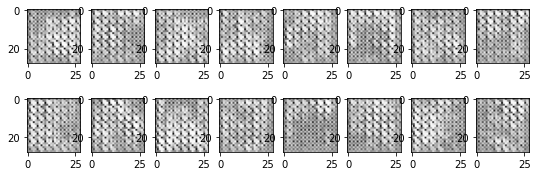

Epoch [3/20], d_loss: 0.5481, g_loss: 0.4205, D(x): 0.00, D(G(z)): 0.33


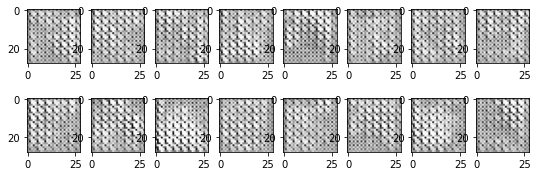

Epoch [4/20], d_loss: 0.5566, g_loss: 0.3967, D(x): 0.00, D(G(z)): 0.33


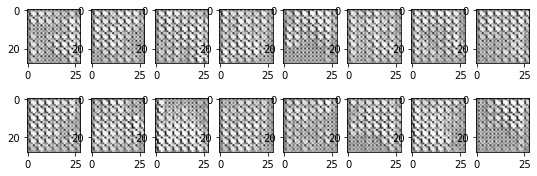

Epoch [5/20], d_loss: 0.5565, g_loss: 0.3976, D(x): 0.00, D(G(z)): 0.33


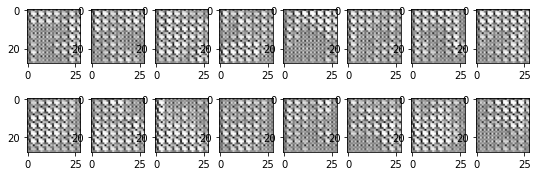

Epoch [6/20], d_loss: 0.5474, g_loss: 0.4104, D(x): 0.00, D(G(z)): 0.33


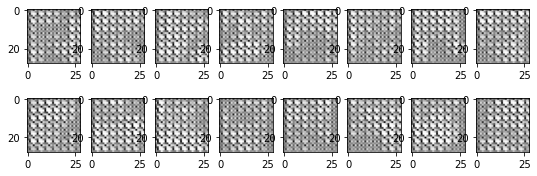

Epoch [7/20], d_loss: 0.5445, g_loss: 0.4136, D(x): 0.00, D(G(z)): 0.34


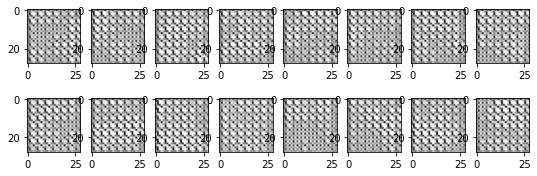

Epoch [8/20], d_loss: 0.5457, g_loss: 0.4179, D(x): 0.00, D(G(z)): 0.34


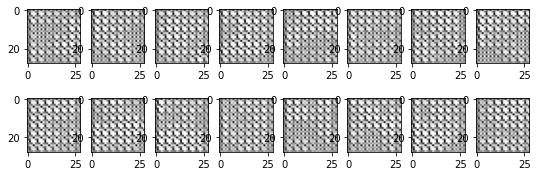

Epoch [9/20], d_loss: 0.5488, g_loss: 0.4085, D(x): 0.00, D(G(z)): 0.33


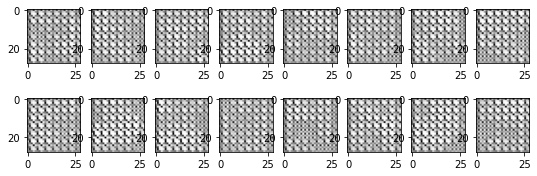

Epoch [10/20], d_loss: 0.5524, g_loss: 0.3887, D(x): 0.00, D(G(z)): 0.33


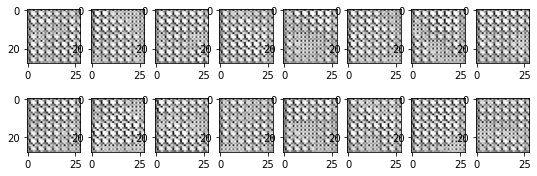

Epoch [11/20], d_loss: 0.5500, g_loss: 0.4066, D(x): 0.00, D(G(z)): 0.33


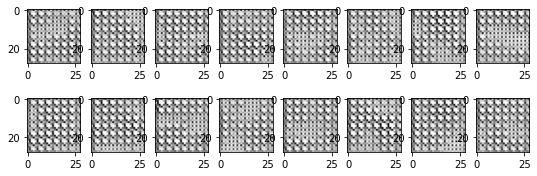

Epoch [12/20], d_loss: 0.5514, g_loss: 0.4049, D(x): 0.00, D(G(z)): 0.33


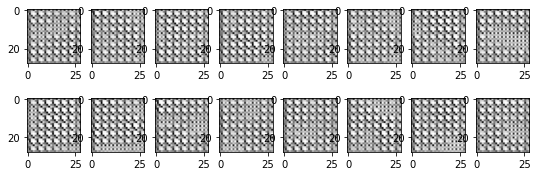

Epoch [13/20], d_loss: 0.5431, g_loss: 0.4068, D(x): 0.00, D(G(z)): 0.34


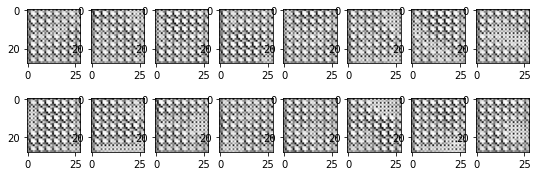

Epoch [14/20], d_loss: 0.5557, g_loss: 0.4051, D(x): 0.00, D(G(z)): 0.33


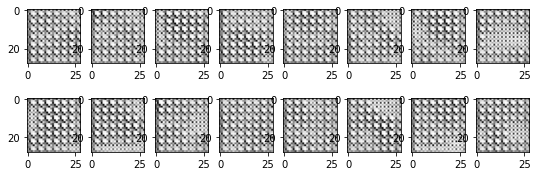

Epoch [15/20], d_loss: 0.5497, g_loss: 0.4082, D(x): 0.00, D(G(z)): 0.33


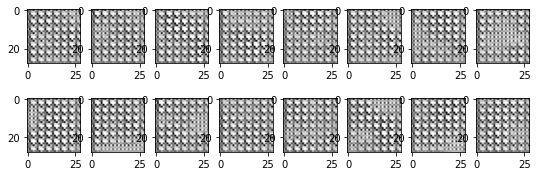

Epoch [16/20], d_loss: 0.5411, g_loss: 0.3982, D(x): 0.00, D(G(z)): 0.34


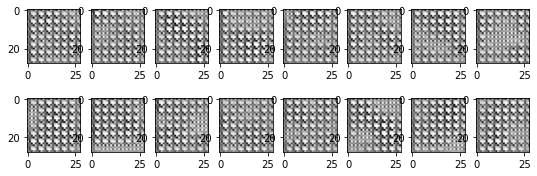

Epoch [17/20], d_loss: 0.5493, g_loss: 0.4069, D(x): 0.00, D(G(z)): 0.33


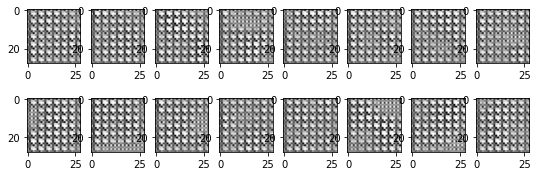

Epoch [18/20], d_loss: 0.5553, g_loss: 0.4024, D(x): 0.00, D(G(z)): 0.33


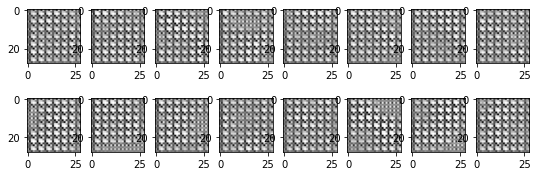

Epoch [19/20], d_loss: 0.5522, g_loss: 0.4053, D(x): 0.00, D(G(z)): 0.33


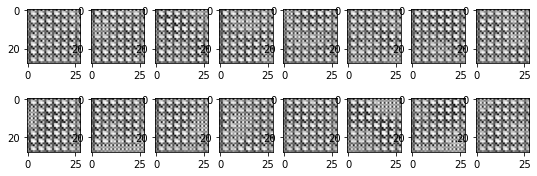

Epoch [20/20], d_loss: 0.5502, g_loss: 0.4056, D(x): 0.00, D(G(z)): 0.33


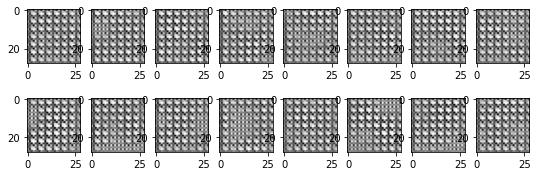

In [ ]:
discriminator = Discriminator()
generator = Generator()
train(generator, discriminator, lr=0.001, num_epochs=20)